In [1]:
import numpy as np   
import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
from networkx.generators.atlas import *
from networkx.algorithms.isomorphism.isomorph import graph_could_be_isomorphic as isomorphic
import random

#EPIDEMIC ON NETWORKS 
#https://epidemicsonnetworks.readthedocs.io/en/latest/GettingStarted.html
#FROM the book 
#Mathematics of Epidemics on Networks: from Exact to Approximate Models
#István Z. KissJoel C. MillerPéter L. Simon
#Springer Link

#Install EON
#pip install EoN
import EoN

from joblib import Parallel, delayed
from itertools import product


#Color palette I love 
#pip install wesanderson 
import wesanderson 
wesanderson.film_palette('Darjeeling Limited')

['#FF0000', '#00A08A', '#F2AD00', '#F98400', '#5BBCD6']

In [2]:
wesanderson.film_palette('Darjeeling Limited',1)

['#ECCBAE', '#046C9A', '#D69C4E', '#ABDDDE', '#000000']

## State correspondent values
0. susceptible pro-vax
1. susceptible hesitant
2. susceptible no-vax
3. infected no-vax
4. infected hesitant
5. infected pro-vax
    
All zero at the beginning:

6. pre vax
7. vax
8. vax adverse reaction 
9. recovered pro-vax 
10.  recovered hesitant
11. recovered no-vax
12. death pro vax
13. death hes
14. death no vax

In [3]:
def init_net_hubs(G, n2, n1, num_hubs, n2_hubs):
    
    '''
    Initialize the network with specific initial conditions.

    - G: Graph representing the network
    - num_hubs: Number of hubs in the network
    - n2_hubs : Number of no-vax in hubs
    - n2: Number of no-vax nodes    
    - n1: number of nodes hesitant

    '''

    N = G.number_of_nodes()
    init = np.zeros(N)

    # Randomly select x nodes from the top nodes with the highest degree (hubs) (will be no-vax)
    top_nodes = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)[:n2_hubs]

    no_vax_hubs = np.random.choice(top_nodes, n2_hubs, replace=False)

    for node in no_vax_hubs:
        init[node] = 2

    for node in no_vax_hubs:
        neighbors = list(G.neighbors(node))
        
        # Filter out neighbors that are already assigned a state of 2
        susceptible_neighbors = [n for n in neighbors if init[n] == 0]
    
        # Sort susceptible neighbors by degree in descending order
        susceptible_neighbors_sorted = sorted(susceptible_neighbors, key=G.degree, reverse=True)
        
        hesitant_neighbors = np.random.choice(susceptible_neighbors, min(n1, len(susceptible_neighbors)), replace=False)
    
        for h_node in hesitant_neighbors:
            if init[h_node] == 0:  # Only change to state 1 if the node is still susceptible
                init[h_node] = 1
        
        # Break out of the loop if already assigned n1 hesitant nodes
        if sum(init == 1) >= n1:
            break

    if n2_hubs<n2 or n1>len(neighbors):

        # Calculate the positive differences
        diff_n2 = max(n2 - n2_hubs, 0)
        diff_n1 = max(n1 - sum(init == 1), 0)
        
        if diff_n2 != 0:
            
            # Randomly select nodes without replacement and assign new states
            selected_nodes_n2 = random.sample([node for node, state in enumerate(init) if state == 0], diff_n2)
            # Assign the new states to the selected nodes
            for node in selected_nodes_n2:
                init[node] = 2  # New state for n2 - n2_hubs nodes
                
        if diff_n1 != 1:
            
            selected_nodes_n1 = random.sample([node for node, state in enumerate(init) if state == 0], diff_n1)
            for node in selected_nodes_n1:
                init[node] = 1  # New state for n1 - len(neighbors) nodes

    
    return init

In [4]:
def init_net_periphery(G, n2, n1):
    
    '''
    Initialize the network with specific initial conditions.

    - G: Graph representing the network
    - n2: Number of no-vax nodes    
    - n1: number of nodes hesitant

    '''

    N = G.number_of_nodes()
    init = np.zeros(N)

    # Randomly select x nodes from the top nodes with the lowest degree (will be no-vax)
    lower_nodes = sorted(G.nodes, key=lambda x: G.degree(x), reverse=False)[:n2]

    for node in lower_nodes:
        init[node] = 2

    for node in lower_nodes:
        neighbors = list(G.neighbors(node))
        
        # Filter out neighbors that are already assigned a state of 2
        susceptible_neighbors = [n for n in neighbors if init[n] == 0]
        
        hesitant_neighbors = np.random.choice(susceptible_neighbors, min(n1, len(susceptible_neighbors)), replace=False)
    
        for h_node in hesitant_neighbors:
            if init[h_node] == 0:  # Only change to state 1 if the node is still susceptible
                init[h_node] = 1
        
        # Break out of the loop if already assigned n1 hesitant nodes
        if sum(init == 1) >= n1:
            break
        else: 
            not_finished = True 

    # If the number of neighbors of no-vax nodes is less of n1, assign 1 randomly to n1-neighbors nodes
    if not_finished:
        
        diff_n1 = max(n1 - sum(init==1), 0)

        if diff_n1 != 0:
            
            selected_nodes_n1 = random.sample([node for node, state in enumerate(init) if state == 0], diff_n1)
            for node in selected_nodes_n1:
                init[node] = 1  # New state for n1 - len(neighbors) nodes

    
    return init

In [5]:
def init_net_random(G, n2, n1):
    '''
    Initialize the network with specific initial conditions.

    Parameters:
        - G: Graph representing the network
        - n2: Number of no-vax nodes    
        - n1: Number of hesitant nodes
    
    Returns:
        - init: Initial states of nodes
    '''
    N = G.number_of_nodes()
    init = np.zeros(N)

    # Randomly select n2 nodes to be no-vax
    no_vax_nodes = random.sample(range(N), n2)
    for node in no_vax_nodes:
        init[node] = 2

    #Randomly select n1 nodes to be hesitant
    #hesitant_nodes = random.sample(set(range(N)) - set(no_vax_nodes), n1)
    #hesitant_nodes = random.sample(set(range(N)).difference(set(no_vax_nodes)), n1)
    #hesitant_nodes = random.sample({node for node in range(N) if node not in no_vax_nodes}, n1)
    hesitant_nodes = random.sample([node for node in range(N) if node not in no_vax_nodes], n1)

    for node in hesitant_nodes:
        init[node] = 1

    return init



In [6]:
def simulate_complex_contagion(G, init_states, time_steps):
    '''
    Simulate the complex contagion process on the network.
    
    Parameters:
        - G: Networkx graph representing the network.
        - init_states: Initial states of nodes.
        - threshold: Threshold for node adoption of hesitant/no-vax behavior.
        
    Returns:
        - final_states: Final states of nodes after the simulation.
    '''
    # Initialize states
    current_states = np.copy(init_states)
    
    current_dose = np.zeros_like(current_states)  # Initialize with zeros
    
    # Update values based on current states
    current_dose[current_states == 2] = 1  # If current state is 2, set current dose to 1
    current_dose[current_states == 1] = 0.5  # If current state is 1, set current dose to 0.5

    new_dose =  np.zeros_like(current_states)
    
    # Loop over nodes

    for _ in range(time_steps):
        
        for node in G.nodes():

            if current_states[node] == 1:  # Hesitant node
                
                neighbors = list(G.neighbors(node))

                sum_dose = 0 
                
                for neighbor in neighbors:
                    if current_states[neighbor] == 1:  # Hesitant neighbor
                        sum_dose += np.random.normal(0, 0.3)  # it can give a "positive" or "negative" dose 
                    elif current_states[neighbor] == 2:  # No-vax neighbor
                        sum_dose += np.abs(np.random.normal(0.25, 0.2))
                    else:  # Pro-vax neighbor
                        sum_dose += -np.abs(np.random.normal(-0.01, 0.05))
                
            new_dose[node] = sum_dose + current_dose[node] 
            
        current_dose = np.copy(new_dose)
        current_states = np.where(current_dose >= 1, 2, np.where(current_dose >= 0.5, 1, 0))
    
    
    return current_states


In [7]:
# Randomly sample i0 nodes and update their states to infected

def init_infection(G, i0, init):

    '- i0: number of nodes initially infected'
    
    N = G.number_of_nodes()
    
    infected_nodes = np.random.choice(range(N), i0, replace=False)
    
    for node in infected_nodes: 
        if init[node] == 0:
            init[node] = 5  # State 5 for initially infected pro-vax nodes
        elif init[node] == 1:
            init[node] = 4  # State 4 for initially infected hesitant nodes
        elif init[node] == 2:
            init[node] = 3  # State 3 for initially infected no-vax nodes
            
    return init

In [8]:
def get_state(G, init):
    
    '''
    init = list of ordered states of each node
    output state = list of [index_node, state_node]

    '''
    
    N = G.number_of_nodes()
    state = np.zeros((N,2))
    for i in range(N):
        state[i,0] = list(nx.nodes(G))[i]
        state[i,1] = init[i] 
  
    return state

# Initialization network 

In [9]:
# let's define the initial configuration of the nodes
N = 1200
m = 2
G = nx.barabasi_albert_graph(N, m)

#nx.draw(G, node_size=10, alpha=0.4, edge_color='black', width=0.35)

### new addition, weights for the connections between nodes----
# Initialize weights for each edge to a random value, for example between 0.1 and 1
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = np.random.uniform(0.1, 0.6) #value max 0.5 considering social distancing (1 is full contact)
###------------------------------------------------------------

# Choose one of the three initializations, addittionally you can add the complex contagion over it 

In [10]:
complex_contagion = False
periphery_init = False
hubs_init = False
random_init = True 

## 1. Initialization no-vax periphery

In [11]:
# # initialize the state of the network placing no-vax in periphery 
# if periphery_init:
#     print("periphery")
#     i0 = 3
#     n1 = int(0.2 * N)
#     n2 = n2_hubs = int(0.05 * N) 
#     num_hubs = int(N * 0.1)
    
#     if complex_contagion:
#         init = init_net_periphery(G, n2, n1)
#     else: 
#         init_no_inf = init_net_periphery(G, n2, n1)
#         init = init_infection(G, i0, init_no_inf) 
        
#     # Verify initialization
#     print("Initialization:")
#     print(init)
    
#     # get the initial state
#     state_init = get_state(G, init)

In [12]:
def periphery_in(i0, frac_hesitant, frac_novac,complex_contagion):
    print("periphery")

    n1 = int(frac_hesitant * N)
    n2 = n2_hubs = int(frac_novac * N) 
    num_hubs = int(N * 0.1)
    
    if complex_contagion:
        init = init_net_periphery(G, n2, n1)
        init_no_inf = 0 
    else: 
        init_no_inf = init_net_periphery(G, n2, n1)
        init = init_infection(G, i0, init_no_inf) 
        
    # Verify initialization
    print("Initialization:")
    print(init)
    
    # get the initial state
    state_init = get_state(G, init)
    return init_no_inf, init, state_init

In [13]:
if periphery_init:
    i0 = 3
    frac_hesitant = 0.2
    frac_novac = 0.05
    init_no_inf, init, state_init = periphery_in(i0, frac_hesitant, frac_novac, complex_contagion=False)

## 2. Initialization no-vax hubs

In [14]:
# # initialize the state of the network placing no-vax in hubs 
# if hubs_init:
#     print("hubs")
#     i0 = 3
#     n1 = int(0.2 * N)
#     n2 = n2_hubs = int(0.05 * N) 
#     num_hubs = int(N * 0.1)
    
#     if complex_contagion:
#         init = init_net_hubs(G, n2, n1, num_hubs, n2_hubs)
#     else: 
#         init_no_inf = init_net_hubs(G, n2, n1, num_hubs, n2_hubs)
#         init = init_infection(G, i0, init_no_inf) 
    
#     # Verify initialization
#     #print("Initialization:")
#     #print(init)
    
#     # get the initial state
#     state_init = get_state(G, init)

In [15]:
def hubs_in(i0, frac_hesitant, frac_novac, complex_contagion):
    print("hubs")
    n1 = int(frac_hesitant * N)
    n2 = n2_hubs = int(frac_novac * N) 
    num_hubs = int(N * 0.1)
    
    if complex_contagion:
        init = init_net_hubs(G, n2, n1, num_hubs, n2_hubs)
        init_no_inf = 0
    else: 
        init_no_inf = init_net_hubs(G, n2, n1, num_hubs, n2_hubs)
        init = init_infection(G, i0, init_no_inf) 
    
    # Verify initialization
    #print("Initialization:")
    #print(init)
    
    # get the initial state
    state_init = get_state(G, init)
    return init_no_inf, init, state_init

In [16]:
if hubs_init:
    i0 = 3
    frac_hesitant = 0.2
    frac_novac = 0.05
    init_no_inf, init, state_init = hubs_in(i0, frac_hesitant, frac_novac, complex_contagion=False)

## 3. Initialization random 

In [17]:
# # initialize the state of the network randomly 
# if random_init:
#     print("random")
#     i0 = 3
#     n1 = int(0.2 * N)
#     n2 = int(0.05 * N) 
    
    
#     if complex_contagion:
#         init = init_net_random(G, n2, n1)
#     else: 
#         init_no_inf = init_net_random(G, n2, n1)
#         init = init_infection(G, i0, init_no_inf) 
    
#     # get the initial state
#     state_init = get_state(G, init)    

In [18]:
def random_in(i0, frac_hesitant, frac_novac, complex_contagion):
    print("random")
    n1 = int(frac_hesitant * N)
    n2 = n2_hubs = int(frac_novac * N) 


    if complex_contagion:
        init = init_net_random(G, n2, n1)
        init_no_inf = 0
    else: 
        init_no_inf = init_net_random(G, n2, n1)
        init = init_infection(G, i0, init_no_inf) 

    # get the initial state
    state_init = get_state(G, init)
    return init_no_inf, init, state_init

In [19]:
if random_init:
    i0 = 3
    frac_hesitant = 0.2
    frac_novac = 0.05
    init_no_inf, init, state_init = random_in(i0, frac_hesitant, frac_novac, complex_contagion=False)

random


## Visualize plot

In [20]:
print("Pro-vax", np.sum(state_init[:,1]==0), "Hesitant", np.sum(state_init[:,1]==1), "No-vax", np.sum(state_init[:,1]==2))
if complex_contagion == False:
    print("Infected Pro-vax", np.sum(state_init[:,1]==5), "Infected Hesitant", np.sum(state_init[:,1]==4), "Infected No-vax", np.sum(state_init[:,1]==3))

Pro-vax 897 Hesitant 240 No-vax 60
Infected Pro-vax 3 Infected Hesitant 0 Infected No-vax 0


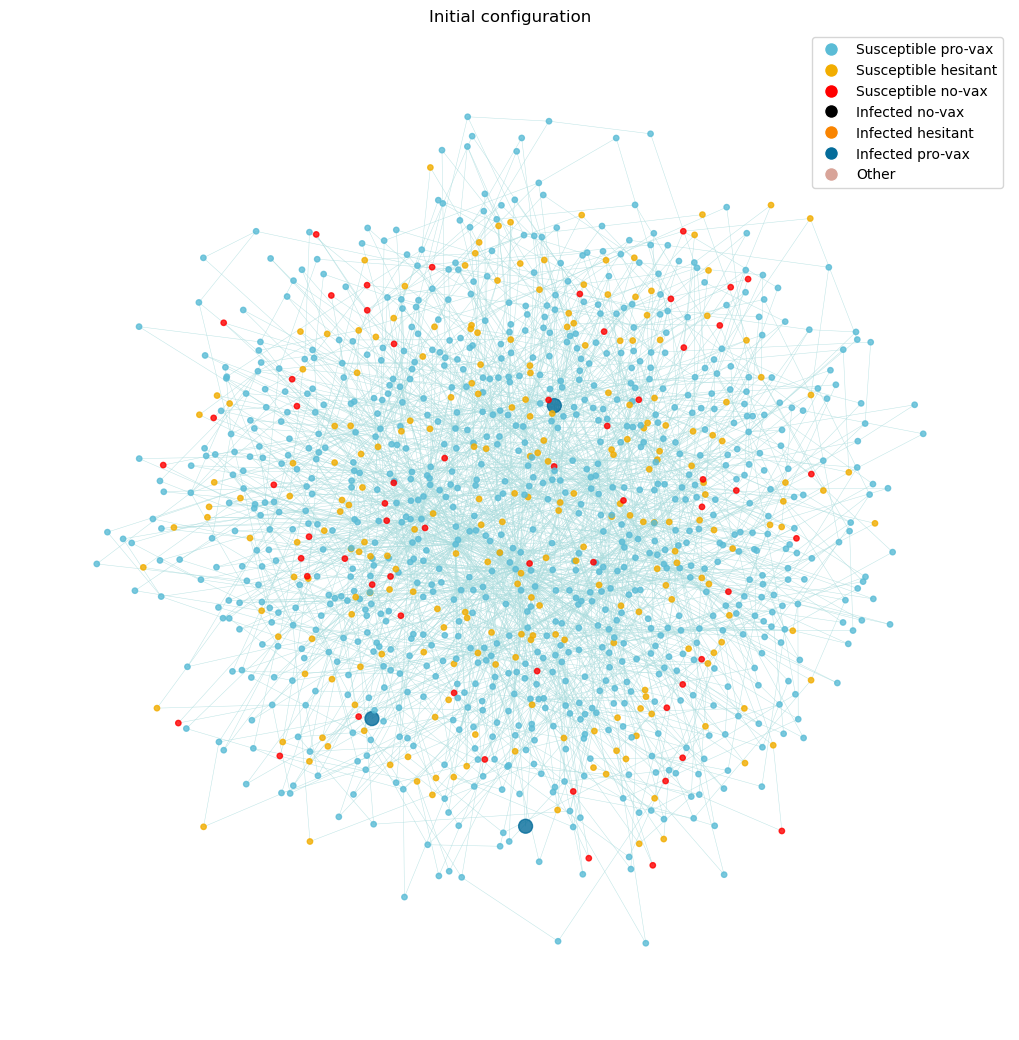

In [21]:
# plot the initial configuration
plt.figure(figsize=(10, 10))

# Define node colors based on states
node_colors = [
    '#5BBCD6' if s == 0 else
    '#FF0000' if s == 2 else
    '#F2AD00' if s == 1 else
    '#000000' if s == 3 else
    '#F98400' if s == 4 else
    '#046C9A' if s == 5 else
    '#D8A499' for s in state_init[:, 1]
]

# Define node size based on states
node_size = [
    100 if s in [3, 4, 5] else
    15 for s in state_init[:, 1]
]

# Draw the network 
nx.draw(
    G, 
    node_color=node_colors, 
    node_size=node_size, 
    alpha=0.8, 
    edge_color='#ABDDDE',
    width=0.35
)

plt.title('Initial configuration')

# legend
legend_labels = {
    0: 'Susceptible pro-vax',
    1: 'Susceptible hesitant',
    2: 'Susceptible no-vax',
    3: 'Infected no-vax',
    4: 'Infected hesitant',
    5: 'Infected pro-vax',
    'other': 'Other'
}

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
    for color, label in zip(['#5BBCD6', '#F2AD00', '#FF0000', '#000000', '#F98400', '#046C9A', '#D8A499'], legend_labels.values())
]

plt.legend(handles=legend_elements, loc='best')
plt.savefig("net_hub.png")
plt.show()


## Add complex contagion if you want 

In [22]:
if complex_contagion:
    time_steps = 3
    complex_cont = simulate_complex_contagion(G, init, time_steps)
    init = init_infection(G, i0, complex_cont)
    state_init = get_state(G, init)

In [23]:
print("Pro-vax", np.sum(state_init[:,1]==0), "Hesitant", np.sum(state_init[:,1]==1), "No-vax", np.sum(state_init[:,1]==2), "Infected Pro-vax", np.sum(state_init[:,1]==5), "Infected Hesitant", np.sum(state_init[:,1]==4), "Infected No-vax", np.sum(state_init[:,1]==3))

Pro-vax 897 Hesitant 240 No-vax 60 Infected Pro-vax 3 Infected Hesitant 0 Infected No-vax 0


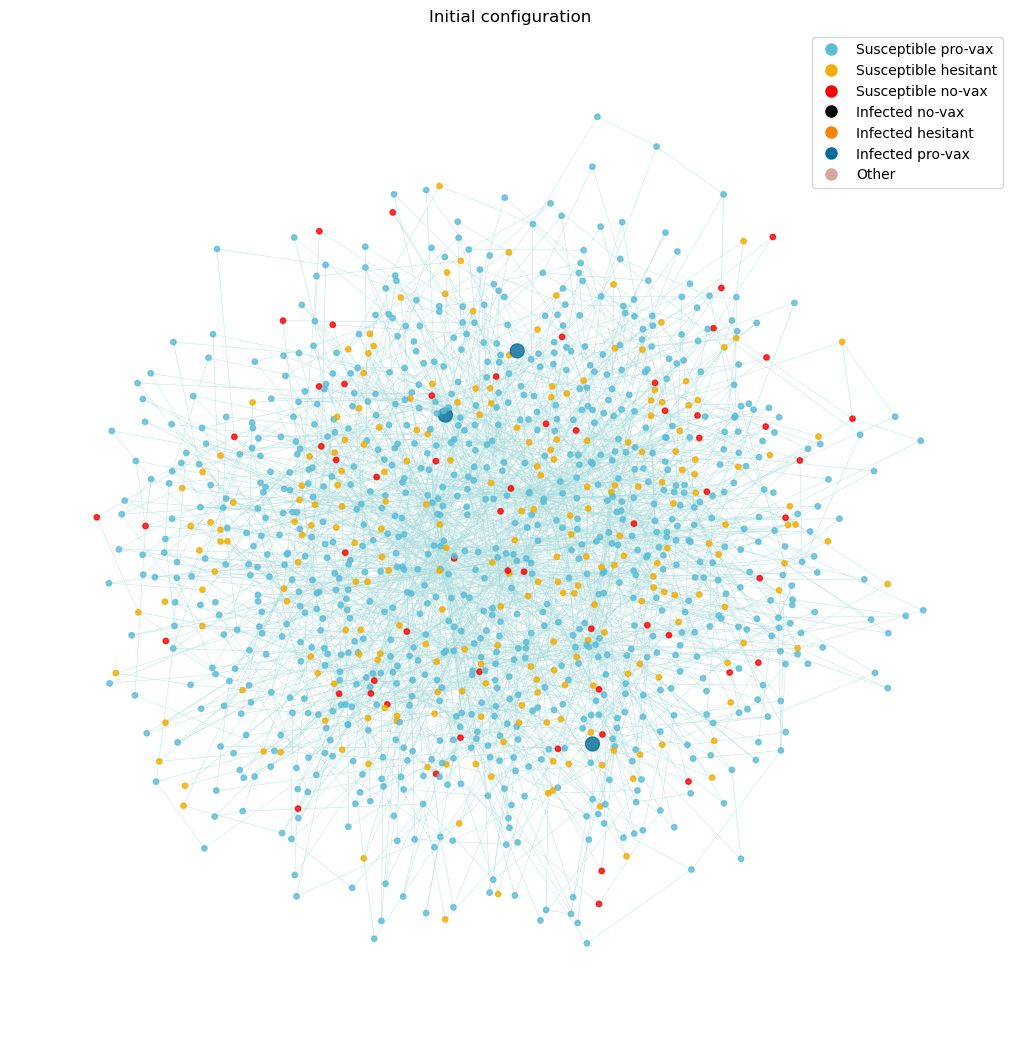

In [24]:
# plot the initial configuration
plt.figure(figsize=(10, 10))

# Define node colors based on states
node_colors = [
    '#5BBCD6' if s == 0 else
    '#FF0000' if s == 2 else
    '#F2AD00' if s == 1 else
    '#000000' if s == 3 else
    '#F98400' if s == 4 else
    '#046C9A' if s == 5 else
    '#D8A499' for s in state_init[:, 1]
]

# Define node size based on states
node_size = [
    100 if s in [3, 4, 5] else
    15 for s in state_init[:, 1]
]

# Draw the network 
nx.draw(
    G, 
    node_color=node_colors, 
    node_size=node_size, 
    alpha=0.8, 
    edge_color='#ABDDDE',
    width=0.35
)

plt.title('Initial configuration')

# legend
legend_labels = {
    0: 'Susceptible pro-vax',
    1: 'Susceptible hesitant',
    2: 'Susceptible no-vax',
    3: 'Infected no-vax',
    4: 'Infected hesitant',
    5: 'Infected pro-vax',
    'other': 'Other'
}

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
    for color, label in zip(['#5BBCD6', '#F2AD00', '#FF0000', '#000000', '#F98400', '#046C9A', '#D8A499'], legend_labels.values())
]

plt.legend(handles=legend_elements, loc='best')
plt.show()


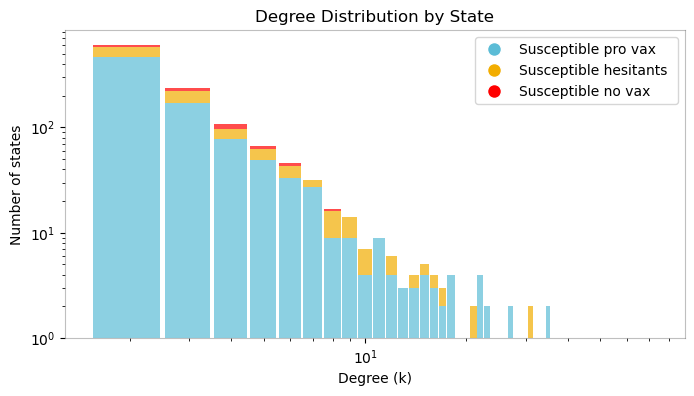

In [25]:
# Probability density function of the degrees in the network
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # sorted list of the degrees of all nodes
degree_seq_unique = np.unique(degree_sequence, return_counts=False)  # list of all possible degrees
degree_count = np.unique(degree_sequence, return_counts=True)  # frequency of each degree in the network

# state_degree --> [number of the node; state; degree]
N = G.number_of_nodes()
state_degree = np.zeros((N, 3))
for i, node in enumerate(G.nodes()):
    state_degree[i, 0] = node
    state_degree[i, 1] = init[i]
    state_degree[i, 2] = G.degree(node)

# Calculate the percentage of each state for each degree

percentage_by_degree = {}
for d in degree_seq_unique:
    perc_h, perc_n, perc_v, perc_other = 0, 0, 0, 0
    for i in range(N):
        if state_degree[i, 2] == d:
            if state_degree[i, 1] == 1:
                perc_h += 1
            elif state_degree[i, 1] == 2:
                perc_n += 1
            elif state_degree[i, 1] == 0:
                perc_v += 1
            else:
                perc_other += 1

    total_states = perc_h + perc_n + perc_v + perc_other
    total_states = 1
    if total_states > 0:
        percentage_by_degree[d] = (perc_v / total_states, perc_h / total_states, perc_n / total_states,
                                   perc_other / total_states)
        
        #print(perc_h , perc_v, perc_n)
    else:
        percentage_by_degree[d] = (0, 0, 0, 0)

# Plot the degree distribution with bars divided by colors
fig, ax = plt.subplots(figsize=(8,4))
bottom = np.zeros(len(degree_seq_unique))

for state in range(3):
    color ='#5BBCD6' if state == 0 else '#FF0000' if state == 2 else '#F2AD00' if state == 1 else '#000000' if state == 3 else '#F98400' if state == 4 else '#046C9A' if state == 5 else '#D8A499'
    state_percentages = np.array([percentage_by_degree[d][state] for d in degree_seq_unique])
    p = ax.bar(degree_seq_unique, state_percentages, 0.9, label=f"State {state}", bottom=bottom, color=color, alpha=0.7)
    bottom += state_percentages

ax.set_title("Degree Distribution by State")
ax.set_xlabel("Degree (k)")
ax.set_ylabel("Number of states")
plt.yscale("log")
plt.xscale("log")

legend_labels = {
    0: 'Susceptible pro vax ',
    1: 'Susceptible hesitants ',
    2: 'Susceptible no vax',
    #3: 'Infected no vax',
    #4: 'Infected hesitants',
    #5: 'Infected pro vax'
}
plt.gca().spines['top'].set_color('gray')  # Top spine
plt.gca().spines['right'].set_color('gray')  # Right spine
plt.gca().spines['bottom'].set_color('gray')  # Bottom spine
plt.gca().spines['left'].set_color('gray')  # Left spine

# Adjust the transparency (alpha) of the lines
for spine in plt.gca().spines.values():
    spine.set_alpha(0.5)
    
    
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
    for color, label in zip(['#5BBCD6', '#F2AD00',  '#FF0000', '#000000', '#F98400', '#046C9A', '#D8A499'], legend_labels.values())
]
ax.legend(handles=legend_elements, loc='best')
plt.savefig("Pk_hub.png")

plt.show()


In [21]:
## new additional input and variable changes ------------------
def iterate(G, vac_beta, beta, vac_mu, mu, d_no_vac,d_vac, tau_v, state, i_count,death_count, r_count, vaccine_available, weights):
    '''
    G = graph
    vac_beta = rate of infection for vaccinated people
    beta = rate of infection for non-vaccinated susceptible 
    mu = rate of recovery for non_vaccinated infectious
    state = conditions of each nodes (1/2/3/4/5/6)
    vac_beta = beta for vaccinated state 
    vac_mu = mu for vaccinated state
    d_vac = death rate for vax infected
    d_no_vac = death rate for no vax infected
    tau_v = waiting time for the vaccine to work
    '''
    
### -------------------------------------

    N = G.number_of_nodes()
    # state_next = np.zeros((N,2))
    state_next = np.copy(state)
    #i_count = 0
    #r_count = 0
    adverse_count = 0
    r_vac_count = 0
    death_vac_count = 0 # vax death 9
    #death_count = 0     # non vax death 10
    vaccine_count = 0   # cumulative number of vaccinet people
    v_adverse = 0.5  # rate of being vax with adverse reaction 
    w3, w4, w5, w8, w12, w13, w14 = 1., 1., 1. , 2., 1., 1., 1.  # weights for the summation of people that make hesitants change their mind
    v = 0.05
    
    for i in range(N):

        # recovery of pro vax infected people  
        if state[i, 1] == 5:  # if i is infected and vaccinated, it can recover with probability mu
            if np.random.uniform(0, 1) <= mu:
                # Check for death of vaccinated individuals
                if np.random.uniform(0, 1) <= d_vac:
                    state_next[i, 1] = 12  # death vax
                    death_vac_count +=1
                    death_count +=1
                else:
                    state_next[i, 1] = 9  # recovered pro-vax
                    r_vac_count += 1
                    
        # recovery of non-vaccinated people (non vax)
        elif state[i, 1] == 3:  # if i is infected and not vaccinated or hesitant
            if np.random.uniform(0, 1) <= mu:
                # Check for death of non-vaccinated individuals
                if np.random.uniform(0, 1) <= d_no_vac:
                    state_next[i, 1] = 14  # death no-vax
                    death_count +=1
                else:
                    state_next[i, 1] = 11  # recovered no-vax
                    r_count += 1
                    
        # recovery of non-vaccinated people (hesitant)
        elif state[i, 1] == 4:  # if i is infected and not vaccinated or hesitant
            if np.random.uniform(0, 1) <= mu:
                # Check for death of non-vaccinated individuals
                if np.random.uniform(0, 1) <= d_no_vac:
                    state_next[i, 1] = 13  # death no-vax
                    death_count +=1
                else:
                    state_next[i, 1] = 10  # recovered no-vax
                    r_count += 1
                    
        # from susc pro vax to pre vax 
        elif state[i, 1] == 0 and vaccine_count < vaccine_available:
                if np.random.uniform(0, 1) <= v:
                    state_next[i, 1] = 6
                    vaccine_count += 1

        # from susc pre vax to vax: VACCINATION
        elif state[i, 1] == 6 :
            if np.random.uniform(0, 1) <= 1/tau_v:
                if np.random.uniform(0, 1) <= v_adverse:
                        state_next[i, 1] = 8
                        adverse_count +=1
                else:
                    state_next[i, 1] = 7
 
        # infection   
        ## Changed the probability of getting infected based on the weights of neighbours
        elif state[i, 1] == 0 or state[i, 1] == 1 or state[i, 1] == 6  or state[i, 1] == 2:  # for all 4 conditions of susceptible
            neighbors_i = list(nx.all_neighbors(G, i))  # neighbors of i-th node
            states_neighbors_i = state[neighbors_i, 1]  # state of neighbors of i-th node

            total_weight = sum(G[i][j]['weight'] for j in neighbors_i)  # total weight of edges to all neighbors

            for j in neighbors_i:
                if state[j, 1] == 3 or state[j, 1] == 4 or state[j, 1] == 5: # if the neighbor is infected
                    neighbor_weight = G[i][j]['weight']  # Weight of edge to the infected neighbor
                    infection_rate = (beta * neighbor_weight) / total_weight

                    if np.random.uniform(0, 1) <= infection_rate:
                        if state[i, 1] == 0 or state[i, 1] == 6:
                            state_next[i, 1] = 5
                        elif state[i, 1] == 1:
                            state_next[i, 1] = 4
                        else:
                            state_next[i, 1] = 3  
                        i_count += 1
                        break  # stop checking the neighbor once already infected  

        elif state[i, 1] == 7 or state[i, 1] == 8:
            neighbors_i = list(nx.all_neighbors(G, i))  # neighbors of i-th node
            states_neighbors_i = state[neighbors_i, 1]  # state of neighbors of i-th node

            total_weight = sum(G[i][j]['weight'] for j in neighbors_i)  # total weight of edges to all neighbors

            for j in neighbors_i:
                if state[j, 1] == 3 or state[j, 1] == 4 or state[j, 1] == 5:  # if the neighbor is infected
                    neighbor_weight = G[i][j]['weight']  # Weight of edge to the infected neighbor
                    infection_rate = (vac_beta * neighbor_weight) / total_weight 

                    if np.random.uniform(0, 1) <= infection_rate:
                        state_next[i, 1] = 5
                        i_count += 1
                        break  # stop checking the neighbor once already infected  

        total_contribution = np.sum(((state[:, 1] == 3) + (state[:, 1] == 4) + (state[:, 1] == 5)) * weights[0]  + 
                                (state[:, 1] == 12) * weights[2] + ((state[:, 1] == 13) + (state[:, 1] == 14)) * weights[3] + 
                                (state[:, 1] == 8) * weights[1])/(weights[0]+weights[1]+weights[2]+weights[3])
        
#         print('Total contribution', total_contribution/N)
        # from hesistant to pro vax

        
        # Calculate the fraction of infected individuals
        infected_fraction = np.sum((state[:, 1] == 3) | (state[:, 1] == 4) | (state[:, 1] == 5)) / 400


        if state[i, 1] == 1:  # if i is a susceptible hesitant node

            # Generate a random number between 0 and 1
            random_number = np.random.rand()
            
            # Compare the infected fraction to the random number
            if infected_fraction > random_number:
#             print("cambio idea?")
                neighbors_i = list(nx.all_neighbors(G, i))  # neighbors of i-th node
                states_neighbors_i = state[neighbors_i, 1]  # state of neighbors of i-th node
                #print(states_neighbors_i)
                # count the neighbors that are in states 3, 8 , death 
                
                
                count_ir = np.sum(
                    ((states_neighbors_i == 3) + (states_neighbors_i == 4) + (states_neighbors_i == 5)) * weights[0] +
                    (states_neighbors_i == 8) * weights[1] +
                    (states_neighbors_i == 12) * weights[2] +
                    ((states_neighbors_i == 13) + (states_neighbors_i == 14)) * weights[3]
                )/(weights[0]+weights[1]+weights[2]+weights[3])
    
    #             print('weights', count_ir/len(neighbors_i))
    
            #Factor to switch believe are from neighbours condition weighted and avg over neighbours + fraction of population that is infected, adverse reaction, and death
                decision = ((2/3)*count_ir/len(neighbors_i))+((1/3)*total_contribution/N)
                
                # Original threshold values
                threshold1 = 0.2
                threshold2 = 0.5
                threshold3 = 0.8
                
                # Standard deviation for Gaussian noise
                std_dev = 0.05  # Adjust this value as needed
                
                # Add Gaussian noise to the thresholds
                threshold1 += np.random.normal(scale=std_dev)
                threshold2 += np.random.normal(scale=std_dev)
                threshold3 += np.random.normal(scale=std_dev)
                
                # Ensure thresholds stay within valid range (0 to 1)
                threshold1 = np.clip(threshold1, 0, 1)
                threshold2 = np.clip(threshold2, 0, 1)
                threshold3 = np.clip(threshold3, 0, 1)
                
                # Decision variable (sample from a uniform distribution)
                decision = np.random.uniform()
                
                # Check decision against the stochastic thresholds
                if threshold1 < decision < threshold2:
                    state_next[i, 1] = 2  # change state to 2 (susceptible no vax)
                elif threshold3 < decision:
                    state_next[i, 1] = 0  # change state to 0 (susceptible pro vax)


    return state_next, i_count, r_count, r_vac_count, death_count, vaccine_count


## Vaccine protection period from Australian Gov
Whilst partial protection against COVID-19 may be as soon as 12 days after the first dose, this protection is likely to be short lived.

The final dose in the primary course encourages the body to create stronger protection (immunity) against the SARS-CoV-2 virus that causes COVID-19. Individuals may not be fully protected until 7-14 days after this dose.

https://www.health.gov.au/our-work/covid-19-vaccines/is-it-true/is-it-true-how-long-does-it-take-for-the-vaccines-to-work#:~:text=The%20final%20dose%20in%20the,14%20days%20after%20this%20dose.

In [26]:
def SIR_net(G, beta, mu, d_no_vac, d_vac, tau_v, i0, frac_hesitant, frac_novac, vaccine_time, doses, weights, draw):
    '''
    INPUT 
    G : a network
    beta : transmission per link
    mu : recovery rate
    initial_infecteds : node or iterable of nodes that will be infected at the beginning 
    d_vac = death rate for vax infected
    d_no_vac = death rate for no vax infected
    tau_v = waiting time for the vaccine to work
    i0 = number of infected intially
    frac_hesitant = fraction in population that is hesitant about vaccine (0 - 1)
    frac_novac = fraction in population that no vaccine (0 - 1)
    vaccine_time = time step to give vaccine
    doses = vaccine doses in population
    
    
    OUTPUT
    t,S,I,R numpy arrays with series of time steps, and series of number of infected, susceptible, recovered per time step
    i,r numpy arrays of number of nodes that just changed the state to infected, recovered per time step
    state_init numpy arrays of initial state
    state numpy arrays of final state
    '''
    
  
    vac_beta= beta*0.3 #changes of getting infected is lower after vaccination
    vac_mu = mu*1.1 
    i_count = 0
    adverse_count = 0
    death_count = 0
    r_count = 0
    
    
    ## Calling function to get state
    if periphery_init: 
        init_no_inf, init, state_init = periphery_in(i0, frac_hesitant, frac_novac, complex_contagion)
        
    if hubs_init:
        init_no_inf, init, state_init = hubs_in(i0, frac_hesitant, frac_novac, complex_contagion)
        
    if random_init:
        init_no_inf, init, state_init = random_in(i0, frac_hesitant, frac_novac, complex_contagion)
        
    
    # I am lazy to change all variables
    initial_infecteds = init
    state = state_init
        
    
    #state = get_state(G, initial_infecteds)

    T_steps = 500
    N = G.number_of_nodes()
    I, R, S, D, V = np.zeros(T_steps), np.zeros(T_steps), np.zeros(T_steps), np.zeros(T_steps), np.zeros(T_steps)
    I[0] = sum(initial_infecteds == 3) + sum(initial_infecteds == 4) + sum(initial_infecteds == 5)
    S[0] = sum(initial_infecteds == 1) + sum(initial_infecteds == 0) + sum(initial_infecteds == 2)
    
    T = np.arange(T_steps)
    

    i, r = np.zeros(T_steps), np.zeros(T_steps)

    for t in range(1, T_steps):
        
        if t > vaccine_time:  #after some timesteps, vaccine becomes available 
            vaccine_available = doses
        else:  #no vaccine yet
            vaccine_available = 0
        
        state_next, i_count_next, r_count_next, r_vac_count, death_count, vaccine_count = iterate(G, vac_beta, beta, vac_mu, mu, d_no_vac,d_vac, tau_v, state, i_count, death_count, r_count, vaccine_available, weights)
        i_count = i_count_next
        r_count = r_count_next
        state = state_next
        
        S[t] = np.sum(state[:, 1] == 1) + np.sum(state[:, 1] == 2) +  np.sum(state[:, 1] == 0)  
        I[t] = np.sum(state[:, 1] == 3) + np.sum(state[:, 1] == 4) + np.sum(state[:, 1] == 5)
        R[t] = np.sum(state[:, 1] == 9) + np.sum(state[:, 1] == 10) + np.sum(state[:, 1] == 11)
        D[t] = np.sum(state[:, 1] == 12) + np.sum(state[:, 1] == 13) + np.sum(state[:, 1] == 14)
        V[t] = np.sum(state[:, 1] == 7) + np.sum(state[:, 1] == 8)
#         print(np.sum(state[:, 1] == 1))
#         print('This is step', t)

        i[t] = i_count
        r[t] = r_count + r_vac_count
        
        if draw and t % 100 == 0:
            plt.figure()
            node_colors = ['yellow' if s == 1 else 'blue' if s == 2 else 'red' for s in state[:, 1]]
            nx.draw(G, node_color=node_colors, node_size=25, alpha=0.8, edge_color='black', width=0.35)
            plt.title(f'Time Step {t}')
            plt.show()

    return (S, I, R, D, V, T, state_init, state, i, r)
 

In [28]:
## changed the definition of beta and mu to be the value before the vaccination
beta = 0.18
mu = 0.037
d_no_vac = 0.05
d_vac = 0.01
tau_v = 12
i0 = 3
frac_hesitant = 0.2
frac_novac = 0.05
vaccine_time = 120
doses = 500


weights = [1., 3., 2., 3.] 

S, I, R, D, V, T, state_init, state, i, r = SIR_net(G, beta, mu, d_no_vac, d_vac, tau_v, i0, frac_hesitant, frac_novac, vaccine_time, doses, weights, draw=False)

random


# dynamics of hesitants

In [52]:
## new additional input and variable changes ------------------
def iterate(G, vac_beta, beta, vac_mu, mu, d_no_vac,d_vac, tau_v, state, i_count,death_count, r_count, vaccine_available, weights, instant_infected):
    '''
    G = graph
    vac_beta = rate of infection for vaccinated people
    beta = rate of infection for non-vaccinated susceptible 
    mu = rate of recovery for non_vaccinated infectious
    state = conditions of each nodes (1/2/3/4/5/6)
    vac_beta = beta for vaccinated state 
    vac_mu = mu for vaccinated state
    d_vac = death rate for vax infected
    d_no_vac = death rate for no vax infected
    tau_v = waiting time for the vaccine to work
    '''
    
### -------------------------------------

    N = G.number_of_nodes()
    # state_next = np.zeros((N,2))
    state_next = np.copy(state)
    #i_count = 0
    #r_count = 0
    adverse_count = 0
    r_vac_count = 0
    death_vac_count = 0 # vax death 9
    #death_count = 0     # non vax death 10
    vaccine_count = 0   # cumulative number of vaccinet people
    v_adverse = 0.5  # rate of being vax with adverse reaction 
    v = 0.05
    pro_vax_prob = 0  #  to store probability of becoming pro-vax
    no_vax_prob = 0  #  to store probability of becoming no-vax
    count_tot = 0 
    count_pro = 0
    count_no = 0
    weights[4]=0.5
    
    scaling_factor = 0.1
    if instant_infected <= 100:
        scaling_factor = 0.1
    elif 100 < instant_infected <=200:
        scaling_factor = 0.3
    elif 200<instant_infected:
        scaling_factor = 0.5

    # Calculate the number of nodes to change state
    fraction_to_change_state = int(instant_infected * scaling_factor)

    # Ensure that at least one node will change state
    number_nodes_to_change_state = max(1, fraction_to_change_state)
    hesitant_nodes = [i for i in range(N) if state[i, 1]] 
    if len(hesitant_nodes) > 0:
        nodes_to_change_state = np.random.choice(hesitant_nodes,number_nodes_to_change_state, replace=False)
    count_tot =len(nodes_to_change_state)
    
    
    
    
    for i in range(N):

        # recovery of pro vax infected people  
        if state[i, 1] == 5:  # if i is infected and vaccinated, it can recover with probability mu
            if np.random.uniform(0, 1) <= mu:
                # Check for death of vaccinated individuals
                if np.random.uniform(0, 1) <= d_vac:
                    state_next[i, 1] = 12  # death vax
                    death_vac_count +=1
                    death_count +=1
                else:
                    state_next[i, 1] = 9  # recovered pro-vax
                    r_vac_count += 1
                    
        # recovery of non-vaccinated people (non vax)
        elif state[i, 1] == 3:  # if i is infected and not vaccinated or hesitant
            if np.random.uniform(0, 1) <= mu:
                # Check for death of non-vaccinated individuals
                if np.random.uniform(0, 1) <= d_no_vac:
                    state_next[i, 1] = 14  # death no-vax
                    death_count +=1
                else:
                    state_next[i, 1] = 11  # recovered no-vax
                    r_count += 1
                    
        # recovery of non-vaccinated people (hesitant)
        elif state[i, 1] == 4:  # if i is infected and not vaccinated or hesitant
            if np.random.uniform(0, 1) <= mu:
                # Check for death of non-vaccinated individuals
                if np.random.uniform(0, 1) <= d_no_vac:
                    state_next[i, 1] = 13  # death no-vax
                    death_count +=1
                else:
                    state_next[i, 1] = 10  # recovered no-vax
                    r_count += 1
                    
        # from susc pro vax to pre vax 
        elif state[i, 1] == 0 and vaccine_count < vaccine_available:
                if np.random.uniform(0, 1) <= v:
                    state_next[i, 1] = 6
                    vaccine_count += 1

        # from susc pre vax to vax: VACCINATION
        elif state[i, 1] == 6 :
            if np.random.uniform(0, 1) <= 1/tau_v:
                if np.random.uniform(0, 1) <= v_adverse:
                        state_next[i, 1] = 8
                        adverse_count +=1
                else:
                    state_next[i, 1] = 7
 
        # infection   
        ## Changed the probability of getting infected based on the weights of neighbours
        elif state[i, 1] == 0 or state[i, 1] == 1 or state[i, 1] == 6  or state[i, 1] == 2:  # for all 4 conditions of susceptible
            neighbors_i = list(nx.all_neighbors(G, i))  # neighbors of i-th node
            states_neighbors_i = state[neighbors_i, 1]  # state of neighbors of i-th node

            total_weight = sum(G[i][j]['weight'] for j in neighbors_i)  # total weight of edges to all neighbors

            for j in neighbors_i:
                if state[j, 1] == 3 or state[j, 1] == 4 or state[j, 1] == 5: # if the neighbor is infected
                    neighbor_weight = G[i][j]['weight']  # Weight of edge to the infected neighbor
                    infection_rate = (beta * neighbor_weight) / total_weight

                    if np.random.uniform(0, 1) <= infection_rate:
                        if state[i, 1] == 0 or state[i, 1] == 6:
                            state_next[i, 1] = 5
                        elif state[i, 1] == 1:
                            state_next[i, 1] = 4
                        else:
                            state_next[i, 1] = 3  
                        i_count += 1
                        break  # stop checking the neighbor once already infected  

        elif state[i, 1] == 7 or state[i, 1] == 8:
            neighbors_i = list(nx.all_neighbors(G, i))  # neighbors of i-th node
            states_neighbors_i = state[neighbors_i, 1]  # state of neighbors of i-th node

            total_weight = sum(G[i][j]['weight'] for j in neighbors_i)  # total weight of edges to all neighbors

            for j in neighbors_i:
                if state[j, 1] == 3 or state[j, 1] == 4 or state[j, 1] == 5:  # if the neighbor is infected
                    neighbor_weight = G[i][j]['weight']  # Weight of edge to the infected neighbor
                    infection_rate = (vac_beta * neighbor_weight) / total_weight 

                    if np.random.uniform(0, 1) <= infection_rate:
                        state_next[i, 1] = 5
                        i_count += 1
                        break  # stop checking the neighbor once already infected  
                        
                        
        #### Section of hesitant trasition ----------------------------
   
        
        # Identify which states are present in the entire network
        states_present_global = {
            3: np.any(state[:, 1] == 3),
            4: np.any(state[:, 1] == 4),
            5: np.any(state[:, 1] == 5),
            8: np.any(state[:, 1] == 8),
            12: np.any(state[:, 1] == 12),
            13: np.any(state[:, 1] == 13),
            14: np.any(state[:, 1] == 14),
            0: np.any(state[:, 1] == 0),
            1: np.any(state[:, 1] == 1),
            2: np.any(state[:, 1] == 2),
            6: np.any(state[:, 1] == 6),
            9: np.any(state[:, 1] == 9),
            10: np.any(state[:, 1] == 10),
            11: np.any(state[:, 1] == 11)
        }

        
        # Calculate the weighted sum of states for the entire network
        weighted_sum_states_global = np.sum(
            ((state[:, 1] == 3) + (state[:, 1] == 4) + (state[:, 1] == 5)) * weights[0] + #infected
            (state[:, 1] == 8) * weights[3] + #adverse
            (state[:, 1] == 12) * weights[2] + # death vax
            ((state[:, 1] == 13) + (state[:, 1] == 14)) * weights[1] + #death no vax
            ((state[:, 1] == 0) + (state[:, 1] == 1) + (state[:, 1] == 2)+(state[:, 1] ==6) + (state[:, 1] == 9) + (state[:, 1] == 10)+(state[:, 1] == 11)) * weights[4] #all other cases
        )
        
        # Create a mapping from state number to the index in weights
        state_to_index = {3: 0, 4: 0, 5: 0, 8: 3, 12: 2, 13: 1, 14: 1, 0: 4, 1: 4, 2: 4, 6: 4, 9 : 4, 10 : 4, 11 : 4}

        # Calculate the dynamic sum of weights for the present states
        dynamic_sum_weights_global = sum(weights[state_to_index[state]] for state, present in states_present_global.items() if present)

        # Normalize total_contribution by the dynamic sum of weights
        total_contribution = weighted_sum_states_global / dynamic_sum_weights_global if dynamic_sum_weights_global > 0 else 0

        
        # from hesistant to pro vax
        # Calculate the fraction of infected individuals
        #print(infected_fraction)
        if i in nodes_to_change_state:  # if i is a susceptible hesitant node
            
            # Generate a random number between 0 and 1
            #random_number = np.random.rand()
            # Compare the infected fraction to the random number

            #if infected_fraction > 0.1 and infected_fraction > random_number:
#             print("cambio idea?")
            neighbors_i = list(nx.all_neighbors(G, i))  # neighbors of i-th node
            states_neighbors_i = state[neighbors_i, 1]  # state of neighbors of i-th node
            #print(states_neighbors_i)
            
            # Identify which states are present among neighbors
            states_present = {
                3: np.any(states_neighbors_i == 3),
                4: np.any(states_neighbors_i == 4),
                5: np.any(states_neighbors_i == 5),
                8: np.any(states_neighbors_i == 8),
                12: np.any(states_neighbors_i == 12),
                13: np.any(states_neighbors_i == 13),
                14: np.any(states_neighbors_i == 14),
                0: np.any(states_neighbors_i == 0),
                1: np.any(states_neighbors_i == 1),
                2: np.any(states_neighbors_i == 2),
                6: np.any(states_neighbors_i == 6),
                9: np.any(states_neighbors_i == 9),
                10: np.any(states_neighbors_i == 10),
                11: np.any(states_neighbors_i == 11)
            }
                

            unique_states = np.unique(states_neighbors_i)

#             if len(unique_states) == 1:  # If all neighbors have the same state
#                 state_weight = weights[state_to_index[unique_states[0]]]
#                 count_ir = (states_neighbors_i == unique_states[0]).sum() * state_weight / len(neighbors_i)      
#             else:
               # Calculate the weighted sum of states
            weighted_sum_states = np.sum(
                ((states_neighbors_i == 3) + (states_neighbors_i == 4) + (states_neighbors_i == 5)) * weights[0] +
                (states_neighbors_i == 8) * weights[3] +
                (states_neighbors_i == 12) * weights[2] +
                ((states_neighbors_i == 13) + (states_neighbors_i == 14)) * weights[1] +
                ((states_neighbors_i == 0) + (states_neighbors_i == 1) + (states_neighbors_i == 2)+(states_neighbors_i ==6) + (states_neighbors_i == 9) + (states_neighbors_i == 10)+(states_neighbors_i == 11)) * weights[4]
            )

            # Update the calculation of dynamic_sum_weights
            dynamic_sum_weights = np.sum(weights[state_to_index[state]] for state, present in states_present.items() if present)

            # Normalize count_ir by the dynamic sum of weights
            count_ir = weighted_sum_states / dynamic_sum_weights if dynamic_sum_weights > 0 else 0



    #             print('weights', count_ir/len(neighbors_i))
    

            #Factor to switch believe are from neighbours condition weighted and avg over neighbours + fraction of population that is infected, adverse reaction, and death
            decision = ((2/3)*count_ir/len(neighbors_i))+((1/3)*total_contribution/N)/ (total_contribution/N + count_ir/len(neighbors_i))
                
            # Original threshold values
            threshold1 = 0.2
            threshold2 = 0.5
            threshold3 = 0.6

            # Standard deviation for Gaussian noise
            std_dev = 0.05  # Adjust this value as needed

            # Add Gaussian noise to the thresholds
            threshold1 += np.random.normal(scale=std_dev)
            threshold2 += np.random.normal(scale=std_dev)
            threshold3 += np.random.normal(scale=std_dev)

            # Ensure thresholds stay within valid range (0 to 1)
            threshold1 = np.clip(threshold1, 0, 1)
            threshold2 = np.clip(threshold2, 0, 1)
            threshold3 = np.clip(threshold3, 0, 1)

            # Decision variable (sample from a uniform distribution)
            #decision = np.random.uniform()
            print(decision, "\t\t\t", (2/3)*count_ir/len(neighbors_i), "\t\t\t", (1/3)*total_contribution/N)
            # Check decision against the stochastic thresholds
            if threshold3 < decision:
                state_next[i, 1] = 0  # change state to 0 (susceptible pro vax)
                pro_vax_prob +=1                
            elif threshold1 < decision < threshold2:
                state_next[i, 1] = 2  # change state to 2 (susceptible no vax)
                no_vax_prob +=1


    return state_next, i_count, r_count, r_vac_count, death_count, vaccine_count,pro_vax_prob,no_vax_prob, count_tot

In [53]:
def SIR_net(G, beta, mu, d_no_vac, d_vac, tau_v, i0, frac_hesitant, frac_novac, vaccine_time, doses, weights, draw):
    '''
    INPUT 
    G : a network
    beta : transmission per link
    mu : recovery rate
    initial_infecteds : node or iterable of nodes that will be infected at the beginning 
    d_vac = death rate for vax infected
    d_no_vac = death rate for no vax infected
    tau_v = waiting time for the vaccine to work
    i0 = number of infected intially
    frac_hesitant = fraction in population that is hesitant about vaccine (0 - 1)
    frac_novac = fraction in population that no vaccine (0 - 1)
    vaccine_time = time step to give vaccine
    doses = vaccine doses in population
    
    
    OUTPUT
    t,S,I,R numpy arrays with series of time steps, and series of number of infected, susceptible, recovered per time step
    i,r numpy arrays of number of nodes that just changed the state to infected, recovered per time step
    state_init numpy arrays of initial state
    state numpy arrays of final state
    '''
    
  
    vac_beta= beta*0.3#changes of getting infected is lower after vaccination
    vac_mu = mu*1.1 
    i_count = 0
    adverse_count = 0
    death_count = 0
    r_count = 0

    ## Calling function to get state
    if periphery_init: 
        init_no_inf, init, state_init = periphery_in(i0, frac_hesitant, frac_novac, complex_contagion)
        
    if hubs_init:
        init_no_inf, init, state_init = hubs_in(i0, frac_hesitant, frac_novac, complex_contagion)
        
    if random_init:
        init_no_inf, init, state_init = random_in(i0, frac_hesitant, frac_novac, complex_contagion)
        
    
    # I am lazy to change all variables
    initial_infecteds = init
    state = state_init
        
    
    #state = get_state(G, initial_infecteds)

    T_steps = 500
    N = G.number_of_nodes()
    I, R, S, D, V = np.zeros(T_steps), np.zeros(T_steps), np.zeros(T_steps), np.zeros(T_steps), np.zeros(T_steps)
    I[0] = sum(initial_infecteds == 3) + sum(initial_infecteds == 4) + sum(initial_infecteds == 5)
    S[0] = sum(initial_infecteds == 1) + sum(initial_infecteds == 0) + sum(initial_infecteds == 2)
    pro_vax_prob = np.zeros(T_steps)  # Array to store probability of becoming pro-vax
    no_vax_prob = np.zeros(T_steps)  # Array to store probability of becoming no-vax
    tot_prob = np.zeros(T_steps) # prob of decision
    
    T = np.arange(T_steps)
    

    i, r = np.zeros(T_steps), np.zeros(T_steps)
    
    for t in range(1, T_steps):
        
        if t > vaccine_time:  #after some timesteps, vaccine becomes available 
            vaccine_available = doses
        else:  #no vaccine yet
            vaccine_available = 0
        
        state_next, i_count_next, r_count_next, r_vac_count, death_count, vaccine_count, pro_vax_prob_val ,no_vax_prob_val, count_tot_val  = iterate(G, vac_beta, beta, vac_mu, mu, d_no_vac,d_vac, tau_v, state, i_count, death_count, r_count, vaccine_available, weights, I[t-1])
        i_count = i_count_next 
        r_count = r_count_next
        state = state_next
        
        S[t] = np.sum(state[:, 1] == 1) + np.sum(state[:, 1] == 2) +  np.sum(state[:, 1] == 0)  
        I[t] = np.sum(state[:, 1] == 3) + np.sum(state[:, 1] == 4) + np.sum(state[:, 1] == 5)
        R[t] = np.sum(state[:, 1] == 9) + np.sum(state[:, 1] == 10) + np.sum(state[:, 1] == 11)
        D[t] = np.sum(state[:, 1] == 12) + np.sum(state[:, 1] == 13) + np.sum(state[:, 1] == 14)
        V[t] = np.sum(state[:, 1] == 7) + np.sum(state[:, 1] == 8)
        pro_vax_prob[t] = pro_vax_prob_val 
        no_vax_prob[t] = no_vax_prob_val 
        tot_prob[t] = count_tot_val
        
#         print(np.sum(state[:, 1] == 1))
#         print('This is step', t)

        i[t] = i_count
        r[t] = r_count + r_vac_count
        
        if draw and t % 100 == 0:
            plt.figure()
            node_colors = ['yellow' if s == 1 else 'blue' if s == 2 else 'red' for s in state[:, 1]]
            nx.draw(G, node_color=node_colors, node_size=25, alpha=0.8, edge_color='black', width=0.35)
            plt.title(f'Time Step {t}')
            plt.show()

    return (S, I, R, D, V, T, state_init, state, i, r, pro_vax_prob, no_vax_prob, tot_prob)
 

In [57]:
from joblib import Parallel, delayed
import numpy as np

beta = 0.18
mu = 0.037
d_no_vac = 0.05
d_vac = 0.01
tau_v = 12
i0 = 3
frac_hesitant = 0.6
frac_novac = 0.05
vaccine_time = 120
doses = 700 
## weight [infected , death no vax, death vax, adverse, sus]
weights = [0.8, 0.9, 0.3, 0.4, 0.5]

# Define the function to run the simulation for a single run
def run_simulation(G, beta, mu, d_no_vac, d_vac, tau_v, i0, frac_hesitant, frac_novac, vaccine_time, doses, weights):
    # Run the simulation
    S, I, R, D, V, T, state_init, state, i, r, pro_vax_prob, no_vax_prob, tot_prob = SIR_net(G, beta, mu, d_no_vac, d_vac, tau_v, i0, frac_hesitant, frac_novac, vaccine_time, doses, weights, draw=False)
    
    return pro_vax_prob, no_vax_prob, tot_prob, I

# Number of runs to average over
num_runs = 10


# Parallelize the simulation runs
results = Parallel(n_jobs=-1)(
    delayed(run_simulation)(G, beta, mu, d_no_vac, d_vac, tau_v, i0, frac_hesitant, frac_novac, vaccine_time, doses, weights)
    for _ in range(num_runs)
)

# Initialize arrays to store the cumulative probabilities
cumulative_pro_vax_prob = np.zeros_like(results[0][0])
cumulative_no_vax_prob = np.zeros_like(results[0][1])
tot_prob_cum = np.zeros_like(results[0][2])
I_all_cum = np.zeros_like(results[0][3])

# Accumulate the probabilities from all runs
for pro_vax_prob, no_vax_prob, tot_prob, I in results:
    cumulative_pro_vax_prob += pro_vax_prob
    cumulative_no_vax_prob += no_vax_prob
    tot_prob_cum += tot_prob
    I_all_cum += I/num_runs  # Accumulate I_all for averaging later

# Calculate the average probabilities
average_pro_vax_prob = cumulative_pro_vax_prob / num_runs
average_no_vax_prob = cumulative_no_vax_prob / num_runs
tot_prob_avg = tot_prob_cum / num_runs


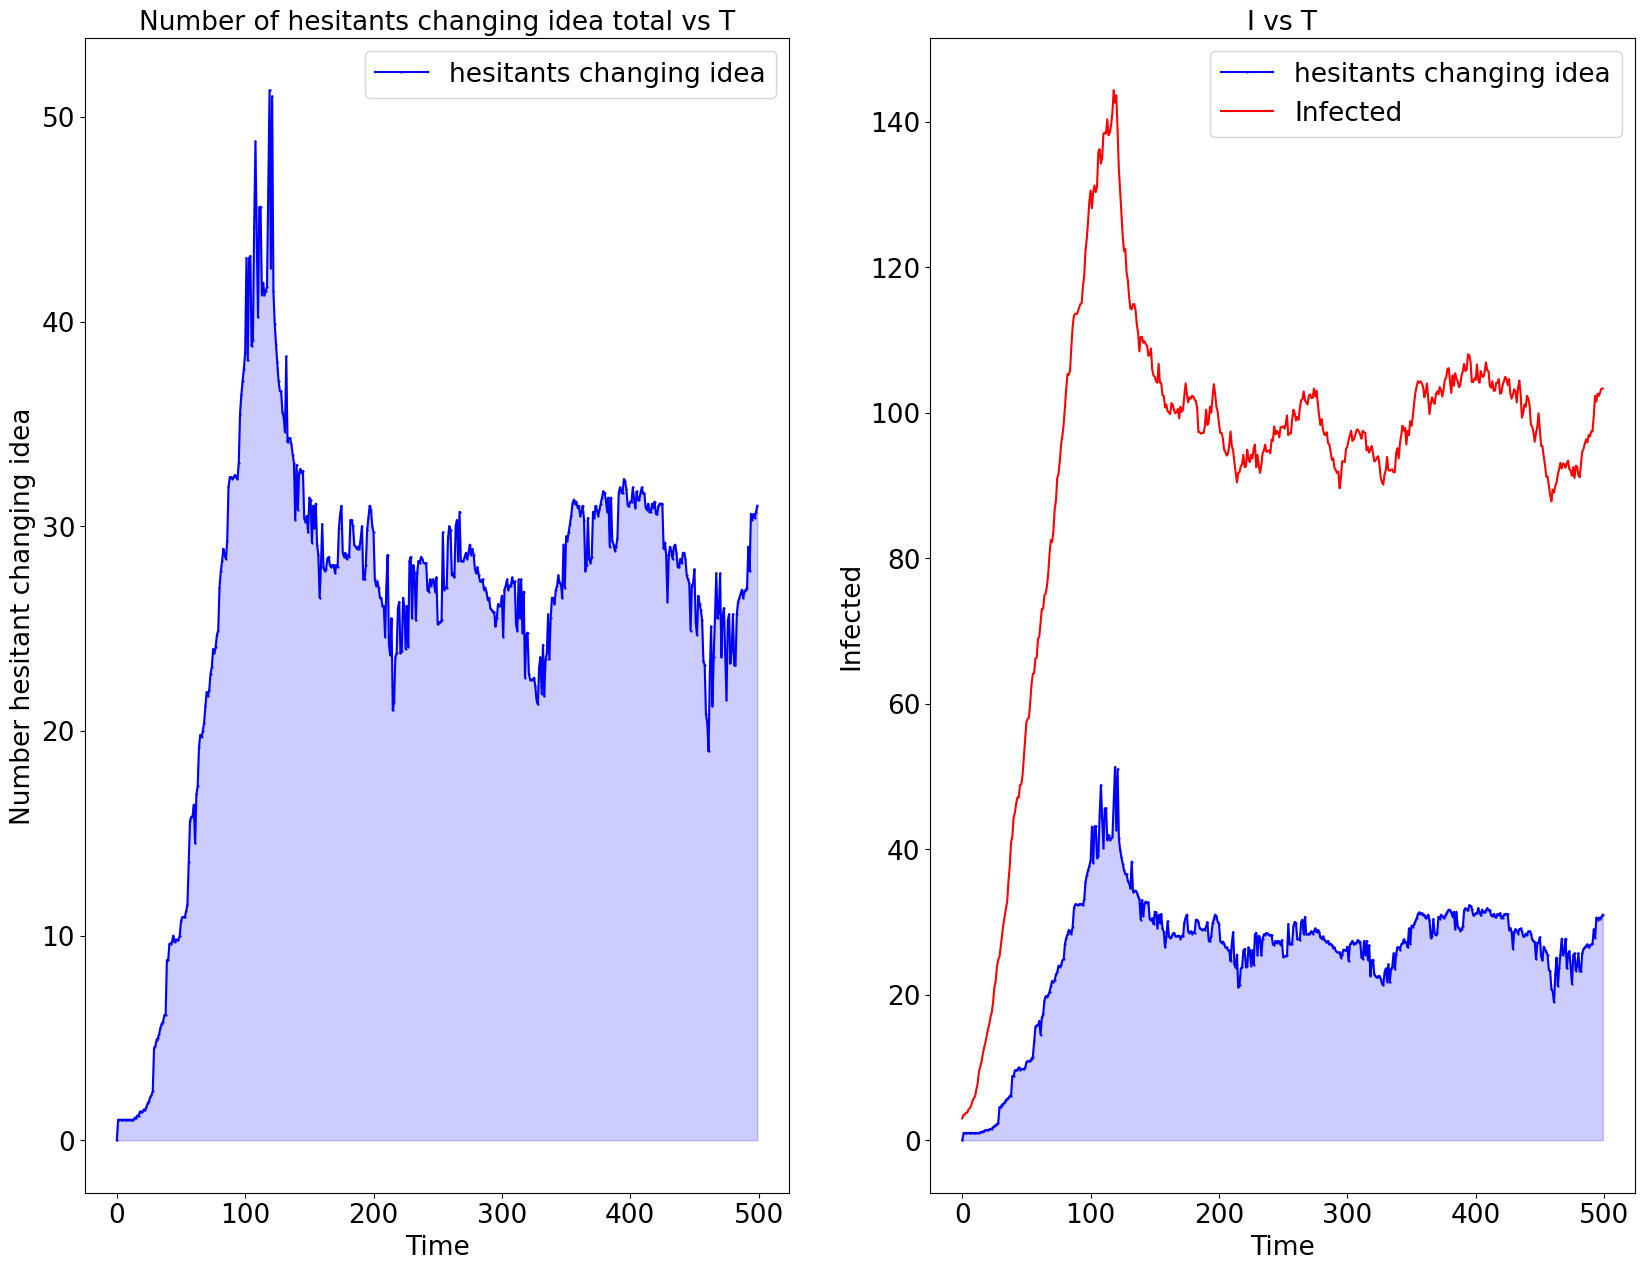

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(20, 15))

# Plotting with shaded regions for standard deviation
num_steps = 500
T = np.arange(num_steps)

# Susceptibles vs Time
axs[0].plot(T, tot_prob_avg, color='blue', linestyle='-', marker='o', markersize='0.6', label='hesitants changing idea')
axs[0].fill_between(T, tot_prob_avg, color='blue', alpha=0.2)  # Filling the area with alpha=0.2
axs[0].set_title('Number of hesitants changing idea total vs T', fontsize=19)
axs[0].set_xlabel('Time', fontsize=19)
axs[0].tick_params(axis='both', which='major', labelsize=19)
axs[0].set_ylabel('Number hesitant changing idea', fontsize=19)

# Infected vs Time
axs[1].plot(T, tot_prob_avg, color='blue', linestyle='-', marker='o', markersize='0.6', label='hesitants changing idea')
axs[1].plot(T, I_all_cum, color='red', linestyle='-', label='Infected')
axs[1].fill_between(T, tot_prob_avg, color='blue', alpha=0.2)  # Filling the area with alpha=0.2
axs[1].set_title('I vs T', fontsize=19)
axs[1].tick_params(axis='both', which='major', labelsize=19)
axs[1].set_xlabel('Time', fontsize=19)
axs[1].set_ylabel('Infected', fontsize=19)

axs[0].legend(fontsize=19)
axs[1].legend(fontsize=19)
plt.savefig("hesitant_dynamics.png")
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


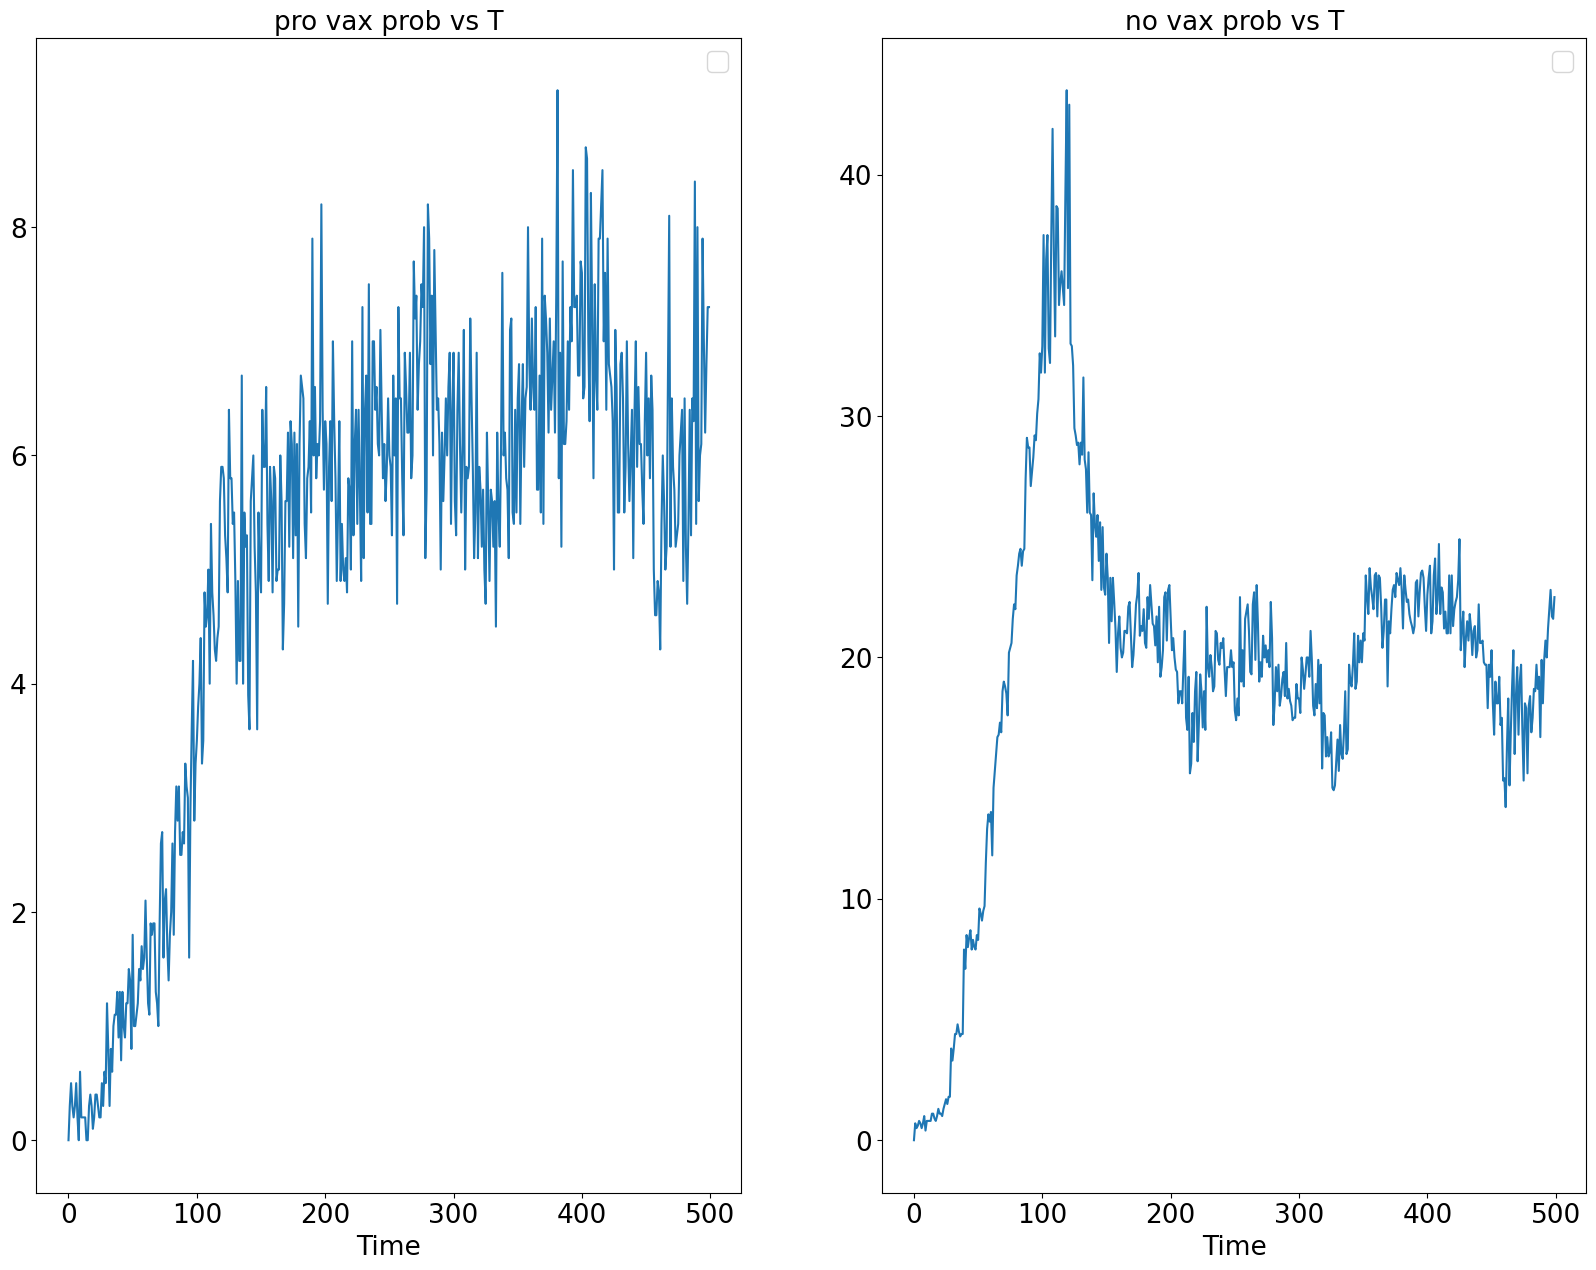

In [59]:
# Plotting with shaded regions for standard deviation
fig, axs = plt.subplots(1, 2, figsize=(20,15))
num_steps = 500
   
# Susceptibles vs Time
axs[0].plot(T,average_pro_vax_prob)
axs[0].set_title('pro vax prob vs T', fontsize=19)


# Infected vs Time
axs[1].plot(T, average_no_vax_prob)
axs[1].set_title('no vax prob vs T', fontsize=19)
plt.savefig("hesitant_dynamics_detail.png")
axs[0].legend(fontsize=19)
axs[1].legend(fontsize=19)
axs[1].set_xlabel('Time', fontsize=19)
axs[0].set_xlabel('Time', fontsize=19)
axs[0].tick_params(axis='both', which='major', labelsize=19)
axs[1].tick_params(axis='both', which='major', labelsize=19)
